# 📊 EDA: Análisis Exploratorio de Datos
## Detección de Hate Speech en YouTube

### Objetivos del EDA:
1. Cargar y explorar el dataset
2. Analizar la distribución de clases (tóxico vs no tóxico)
3. Analizar características del texto (longitud, palabras frecuentes)
4. Identificar patrones en comentarios tóxicos
5. Visualizar insights clave
6. Documentar hallazgos para guiar el preprocesamiento


## 1. Importar librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos


In [2]:
# Definir ruta del dataset
data_path = Path('../data/raw/youtoxic_english_1000.csv')

# Verificar que el archivo existe
if not data_path.exists():
    raise FileNotFoundError(
        f"❌ Dataset no encontrado en {data_path}\n"
        f"Por favor, copia el archivo 'youtoxic_english_1000.csv' a la carpeta 'data/raw/'"
    )

# Cargar dataset
df = pd.read_csv(data_path)

print(f"✅ Dataset cargado: {len(df)} filas, {len(df.columns)} columnas")
print(f"\n📋 Columnas disponibles:")
print(df.columns.tolist())


✅ Dataset cargado: 1000 filas, 15 columnas

📋 Columnas disponibles:
['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']


## 3. Exploración inicial del dataset


In [3]:
# Información general
print("="*80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*80)
print(f"\n📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\n📋 Primeras filas:")
df.head()


INFORMACIÓN GENERAL DEL DATASET

📊 Dimensiones: 1000 filas × 15 columnas

📋 Primeras filas:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [4]:
# Información de tipos de datos y valores nulos
print("="*80)
print("INFORMACIÓN DE COLUMNAS")
print("="*80)
print("\n📊 Tipos de datos:")
print(df.dtypes)
print("\n🔍 Valores nulos:")
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100
null_info = pd.DataFrame({
    'Valores nulos': null_counts,
    'Porcentaje': null_percentages
})
print(null_info[null_info['Valores nulos'] > 0])
if null_info[null_info['Valores nulos'] > 0].empty:
    print("✅ No hay valores nulos")


INFORMACIÓN DE COLUMNAS

📊 Tipos de datos:
CommentId          object
VideoId            object
Text               object
IsToxic              bool
IsAbusive            bool
IsThreat             bool
IsProvocative        bool
IsObscene            bool
IsHatespeech         bool
IsRacist             bool
IsNationalist        bool
IsSexist             bool
IsHomophobic         bool
IsReligiousHate      bool
IsRadicalism         bool
dtype: object

🔍 Valores nulos:
Empty DataFrame
Columns: [Valores nulos, Porcentaje]
Index: []
✅ No hay valores nulos


In [5]:
# Estadísticas descriptivas
print("="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)
df.describe(include='all')


ESTADÍSTICAS DESCRIPTIVAS


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,Ugg2KwwX0V8-aXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


## 4. Análisis de la variable objetivo (Label)


🔍 Columnas de etiquetas encontradas: ['IsToxic']

✅ Usando columna: 'IsToxic'

DISTRIBUCIÓN DE CLASES
         Cantidad  Porcentaje
IsToxic                      
False         538        53.8
True          462        46.2


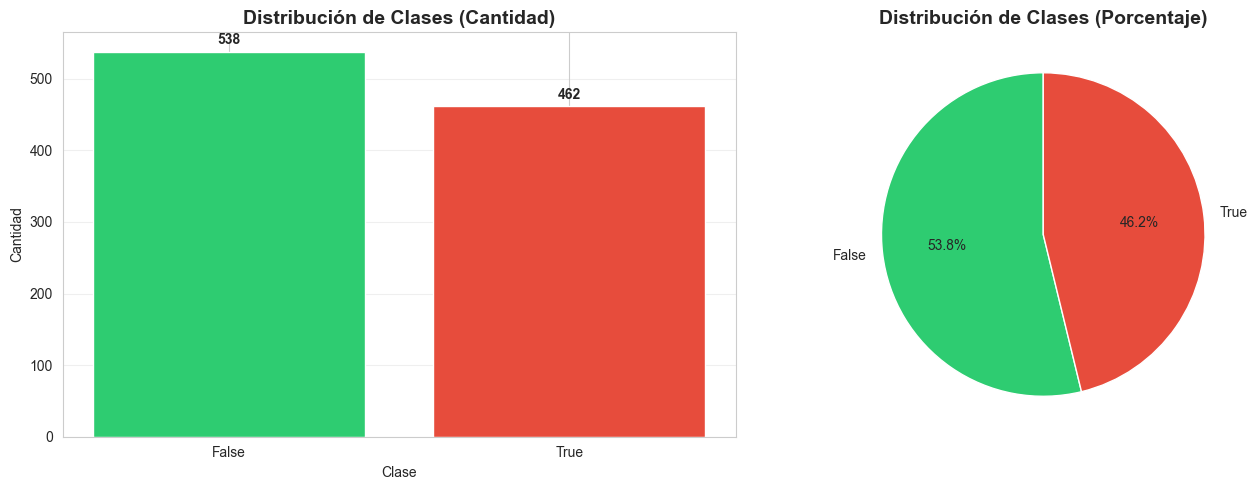


📊 Ratio de balance: 0.859
✅ Dataset relativamente balanceado


In [6]:
# Identificar columna de etiquetas (puede ser 'Label', 'IsToxic', 'Toxic', etc.)
label_cols = [col for col in df.columns if 'label' in col.lower() or 'toxic' in col.lower() or 'target' in col.lower()]
print(f"🔍 Columnas de etiquetas encontradas: {label_cols}")

# Si hay múltiples, usar la principal (Label o IsToxic)
if 'Label' in df.columns:
    label_col = 'Label'
elif 'IsToxic' in df.columns:
    label_col = 'IsToxic'
elif len(label_cols) > 0:
    label_col = label_cols[0]
else:
    raise ValueError("No se encontró columna de etiquetas. Revisa el dataset.")

print(f"\n✅ Usando columna: '{label_col}'")

# Análisis de distribución
print("\n" + "="*80)
print("DISTRIBUCIÓN DE CLASES")
print("="*80)
label_counts = df[label_col].value_counts()
label_percentages = df[label_col].value_counts(normalize=True) * 100

dist_df = pd.DataFrame({
    'Cantidad': label_counts,
    'Porcentaje': label_percentages
})
print(dist_df)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(dist_df.index.astype(str), dist_df['Cantidad'], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribución de Clases (Cantidad)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(dist_df['Cantidad']):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
axes[1].pie(dist_df['Cantidad'], labels=dist_df.index.astype(str), autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Distribución de Clases (Porcentaje)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Balance de clases
balance_ratio = min(label_counts) / max(label_counts)
print(f"\n📊 Ratio de balance: {balance_ratio:.3f}")
if balance_ratio > 0.7:
    print("✅ Dataset relativamente balanceado")
elif balance_ratio > 0.4:
    print("⚠️  Dataset moderadamente desbalanceado")
else:
    print("❌ Dataset muy desbalanceado - considerar técnicas de balanceo")


## 5. Análisis de las columnas de toxicidad


🔍 Columnas de toxicidad encontradas: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsHatespeech', 'IsReligiousHate']

ANÁLISIS DE TIPOS DE TOXICIDAD

📊 Distribución de tipos de toxicidad:

IsToxic:
IsToxic
False    538
True     462
Name: count, dtype: int64

IsAbusive:
IsAbusive
False    647
True     353
Name: count, dtype: int64

IsThreat:
IsThreat
False    979
True      21
Name: count, dtype: int64

IsHatespeech:
IsHatespeech
False    862
True     138
Name: count, dtype: int64

IsReligiousHate:
IsReligiousHate
False    988
True      12
Name: count, dtype: int64


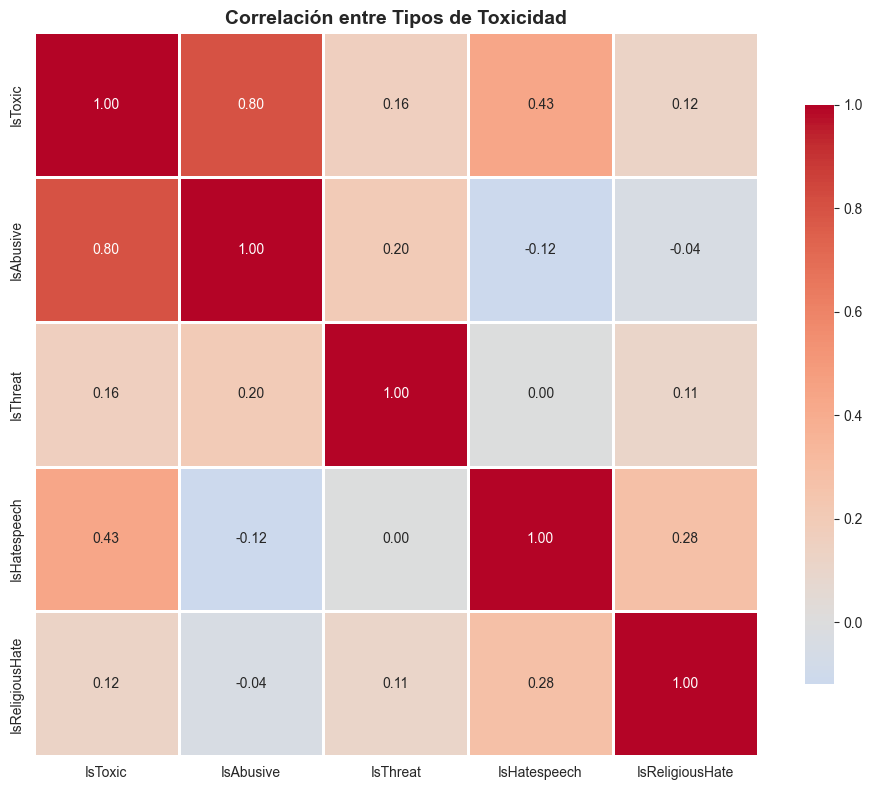

In [7]:
# Buscar columnas relacionadas con tipos de toxicidad
toxicity_cols = [col for col in df.columns if any(word in col.lower() for word in ['abusive', 'hate', 'toxic', 'threat', 'insult'])]
print(f"🔍 Columnas de toxicidad encontradas: {toxicity_cols}")

if len(toxicity_cols) > 0:
    print("\n" + "="*80)
    print("ANÁLISIS DE TIPOS DE TOXICIDAD")
    print("="*80)
    
    # Crear matriz de correlación entre tipos de toxicidad
    toxicity_df = df[toxicity_cols]
    print("\n📊 Distribución de tipos de toxicidad:")
    for col in toxicity_cols:
        print(f"\n{col}:")
        print(toxicity_df[col].value_counts())
    
    # Visualización de correlación
    if len(toxicity_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = toxicity_df.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Correlación entre Tipos de Toxicidad', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("⚠️  No se encontraron columnas adicionales de toxicidad")


## 6. Análisis del texto (comentarios)


In [8]:
# Identificar columna de texto (puede ser 'Text', 'Comment', 'CommentText', etc.)
text_cols = [col for col in df.columns if 'text' in col.lower() or 'comment' in col.lower() or 'message' in col.lower()]
print(f"🔍 Columnas de texto encontradas: {text_cols}")

if len(text_cols) == 0:
    # Si no encuentra, mostrar todas las columnas de tipo object
    text_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"⚠️  No se encontró columna de texto específica. Columnas de tipo object: {text_cols}")

# Usar la primera columna de texto encontrada
text_col = text_cols[0] if len(text_cols) > 0 else None

if text_col:
    print(f"\n✅ Usando columna de texto: '{text_col}'")
    
    # Convertir a string y eliminar nulos
    df[text_col] = df[text_col].astype(str)
    df = df[df[text_col] != 'nan']
    
    # Calcular longitud de comentarios
    df['text_length'] = df[text_col].str.len()
    df['word_count'] = df[text_col].str.split().str.len()
    
    print(f"\n📊 Estadísticas de longitud de texto:")
    print(df[['text_length', 'word_count']].describe())
else:
    raise ValueError("No se encontró columna de texto. Revisa el dataset.")


🔍 Columnas de texto encontradas: ['CommentId', 'Text']

✅ Usando columna de texto: 'CommentId'

📊 Estadísticas de longitud de texto:
       text_length  word_count
count  1000.000000      1000.0
mean     21.056000         1.0
std       2.286064         0.0
min      20.000000         1.0
25%      20.000000         1.0
50%      20.000000         1.0
75%      20.000000         1.0
max      26.000000         1.0


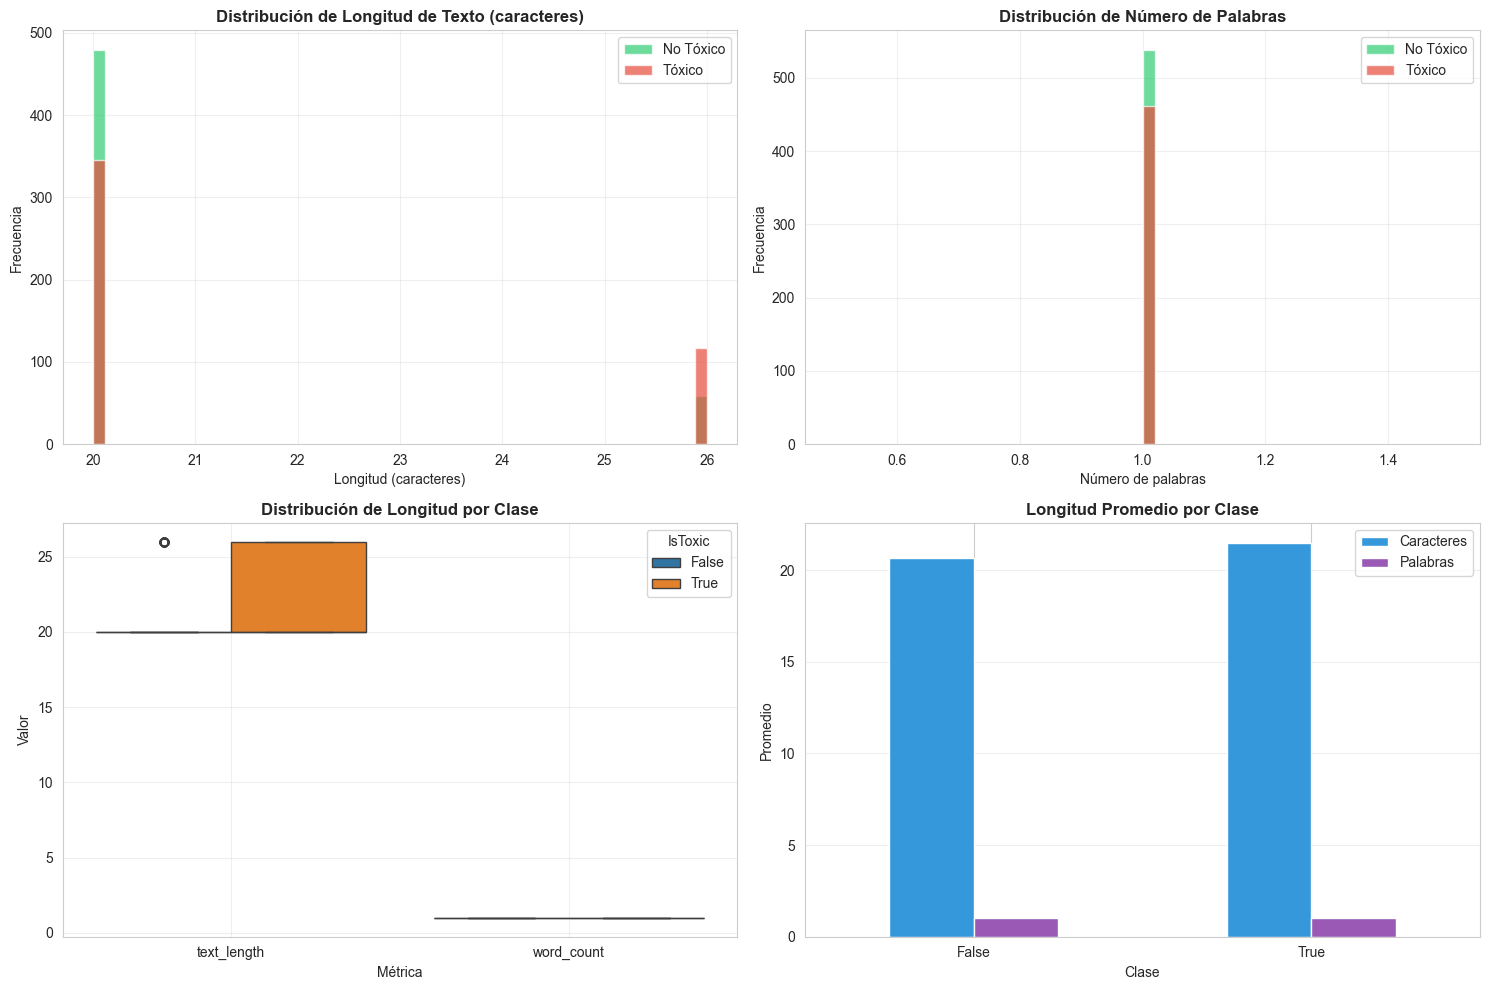


COMPARACIÓN DE LONGITUD POR CLASE
        text_length                  word_count            
               mean median       std       mean median  std
IsToxic                                                    
False     20.657993   20.0  1.876578        1.0    1.0  0.0
True      21.519481   20.0  2.612055        1.0    1.0  0.0


In [9]:
# Visualización de longitud de texto por clase
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de longitud de caracteres
axes[0, 0].hist(df[df[label_col] == 0]['text_length'], bins=50, alpha=0.7, label='No Tóxico', color='#2ecc71')
axes[0, 0].hist(df[df[label_col] == 1]['text_length'], bins=50, alpha=0.7, label='Tóxico', color='#e74c3c')
axes[0, 0].set_xlabel('Longitud (caracteres)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Longitud de Texto (caracteres)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histograma de número de palabras
axes[0, 1].hist(df[df[label_col] == 0]['word_count'], bins=50, alpha=0.7, label='No Tóxico', color='#2ecc71')
axes[0, 1].hist(df[df[label_col] == 1]['word_count'], bins=50, alpha=0.7, label='Tóxico', color='#e74c3c')
axes[0, 1].set_xlabel('Número de palabras')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Número de Palabras', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Boxplot de longitud por clase
df_box = pd.melt(df, id_vars=[label_col], value_vars=['text_length', 'word_count'], 
                 var_name='metric', value_name='value')
sns.boxplot(data=df_box, x='metric', y='value', hue=label_col, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Longitud por Clase', fontweight='bold')
axes[1, 0].set_xlabel('Métrica')
axes[1, 0].set_ylabel('Valor')
axes[1, 0].grid(alpha=0.3)

# Comparación de promedios
avg_length_by_class = df.groupby(label_col)[['text_length', 'word_count']].mean()
avg_length_by_class.plot(kind='bar', ax=axes[1, 1], color=['#3498db', '#9b59b6'])
axes[1, 1].set_title('Longitud Promedio por Clase', fontweight='bold')
axes[1, 1].set_xlabel('Clase')
axes[1, 1].set_ylabel('Promedio')
axes[1, 1].legend(['Caracteres', 'Palabras'])
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print("\n" + "="*80)
print("COMPARACIÓN DE LONGITUD POR CLASE")
print("="*80)
comparison = df.groupby(label_col)[['text_length', 'word_count']].agg(['mean', 'median', 'std'])
print(comparison)


## 7. Análisis de palabras más frecuentes


PALABRAS MÁS FRECUENTES

🔴 Top 20 palabras en comentarios TÓXICOS:
  ugi                  :    4
  ngcoaec              :    3
  ugj                  :    3
  xgcoaec              :    2
  uggsyiwitbnmgngcoaec :    1
  uggte                :    1
  ttczhgcoaec          :    1
  ughanudr             :    1
  rlrqxgcoaec          :    1
  ughbyihvgouqchgcoaec :    1
  ughibnvkzzh          :    1
  xhgcoaec             :    1
  ughmrzgouqmozxgcoaec :    1
  ughnzybgv            :    1
  rhgcoaec             :    1
  ughrklaiosvlohgcoaec :    1
  qhgcoaec             :    1
  ugibznwqmnnyuxgcoaec :    1
  hbddmiukvhgcoaec     :    1
  ugiiasdsnr           :    1

🟢 Top 20 palabras en comentarios NO TÓXICOS:
  ugg                  :    4
  xgcoaec              :    2
  ugj                  :    2
  ugi                  :    2
  axgcoaec             :    1
  ugghkcxz             :    1
  uggyckjvulfbyhgcoaec :    1
  ughckd               :    1
  ayngcoaec            :    1
  ughpy          

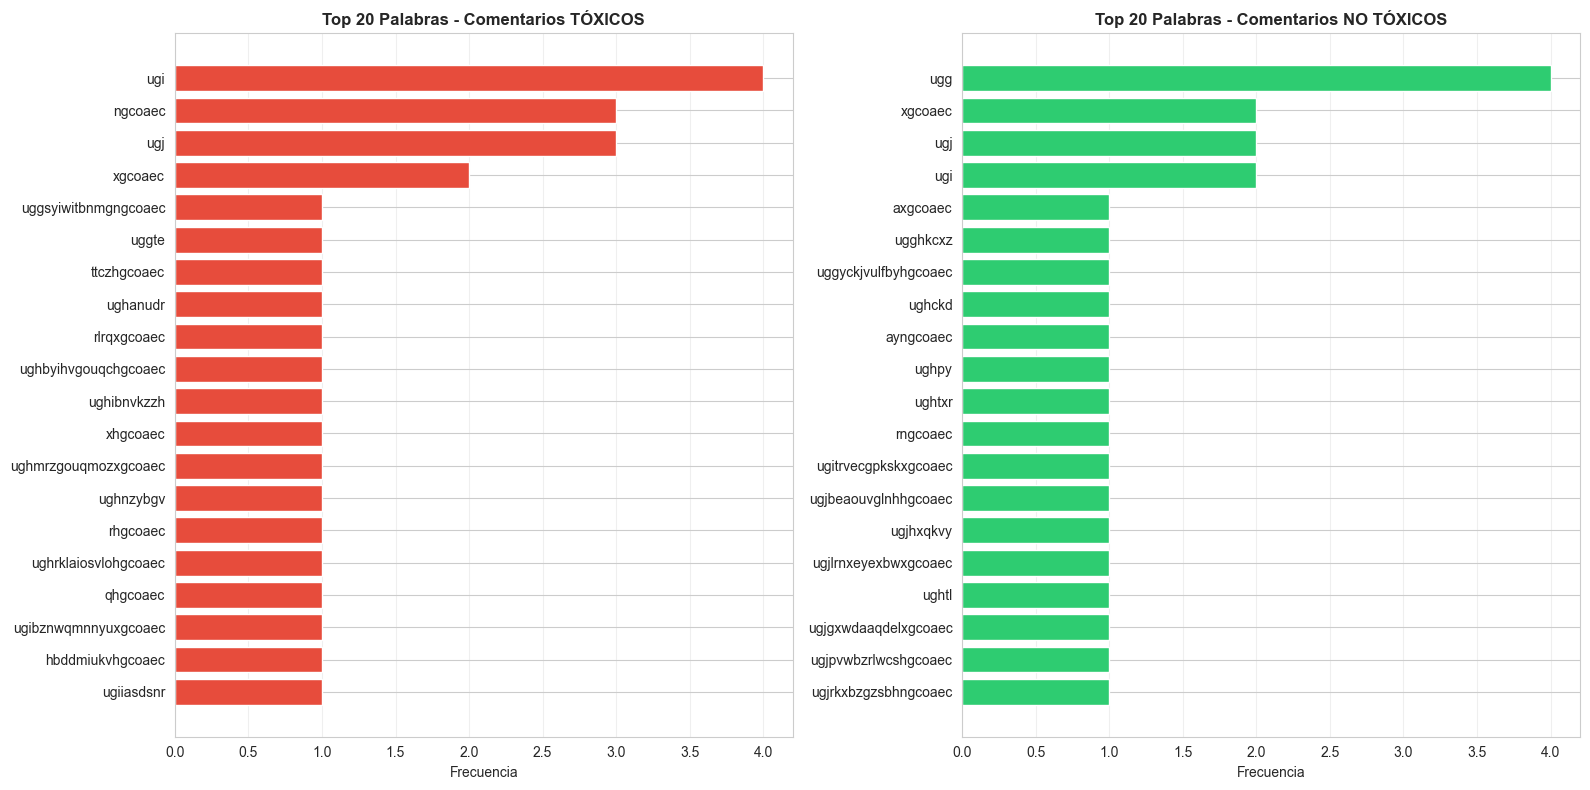

In [10]:
from collections import Counter
import re

def get_top_words(text_series, n=20):
    """Obtiene las n palabras más frecuentes"""
    all_words = []
    for text in text_series:
        # Convertir a minúsculas y extraer palabras
        words = re.findall(r'\b[a-z]+\b', text.lower())
        all_words.extend(words)
    return Counter(all_words).most_common(n)

# Palabras más frecuentes en comentarios tóxicos
toxic_texts = df[df[label_col] == 1][text_col]
toxic_words = get_top_words(toxic_texts, n=20)

# Palabras más frecuentes en comentarios no tóxicos
non_toxic_texts = df[df[label_col] == 0][text_col]
non_toxic_words = get_top_words(non_toxic_texts, n=20)

print("="*80)
print("PALABRAS MÁS FRECUENTES")
print("="*80)

print("\n🔴 Top 20 palabras en comentarios TÓXICOS:")
for word, count in toxic_words:
    print(f"  {word:20s} : {count:4d}")

print("\n🟢 Top 20 palabras en comentarios NO TÓXICOS:")
for word, count in non_toxic_words:
    print(f"  {word:20s} : {count:4d}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Palabras tóxicas
toxic_df = pd.DataFrame(toxic_words, columns=['Palabra', 'Frecuencia'])
axes[0].barh(range(len(toxic_df)), toxic_df['Frecuencia'], color='#e74c3c')
axes[0].set_yticks(range(len(toxic_df)))
axes[0].set_yticklabels(toxic_df['Palabra'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Frecuencia')
axes[0].set_title('Top 20 Palabras - Comentarios TÓXICOS', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Palabras no tóxicas
non_toxic_df = pd.DataFrame(non_toxic_words, columns=['Palabra', 'Frecuencia'])
axes[1].barh(range(len(non_toxic_df)), non_toxic_df['Frecuencia'], color='#2ecc71')
axes[1].set_yticks(range(len(non_toxic_df)))
axes[1].set_yticklabels(non_toxic_df['Palabra'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Frecuencia')
axes[1].set_title('Top 20 Palabras - Comentarios NO TÓXICOS', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Ejemplos de comentarios


In [11]:
print("="*80)
print("EJEMPLOS DE COMENTARIOS")
print("="*80)

print("\n🔴 Ejemplos de comentarios TÓXICOS:")
toxic_samples = df[df[label_col] == 1][text_col].sample(min(5, len(df[df[label_col] == 1])), random_state=42)
for i, comment in enumerate(toxic_samples, 1):
    print(f"\n{i}. {comment[:200]}..." if len(comment) > 200 else f"\n{i}. {comment}")

print("\n\n🟢 Ejemplos de comentarios NO TÓXICOS:")
non_toxic_samples = df[df[label_col] == 0][text_col].sample(min(5, len(df[df[label_col] == 0])), random_state=42)
for i, comment in enumerate(non_toxic_samples, 1):
    print(f"\n{i}. {comment[:200]}..." if len(comment) > 200 else f"\n{i}. {comment}")


EJEMPLOS DE COMENTARIOS

🔴 Ejemplos de comentarios TÓXICOS:

1. UgjR2vUGwXV6ongCoAEC

2. UgheEXayk90xIngCoAEC

3. UghP0v4pSXeRY3gCoAEC

4. UgjGgOEMa0zTS3gCoAEC

5. Uggk77ZgVKBK7ngCoAEC


🟢 Ejemplos de comentarios NO TÓXICOS:

1. Uggq0P2aJlQfangCoAEC

2. Ugi_4iRsu9Skx3gCoAEC

3. UgzGP9zuUw8tkaH1kJh4AaABAg

4. UgjyZIj3j48MXngCoAEC

5. Ugjf1ns-vrD_mHgCoAEC


## 9. Análisis Avanzado: Clustering y Data Augmentation

### 9.1. Análisis de Clustering (KMeans y DBSCAN)

Se realizó un análisis de clustering para identificar patrones ocultos en los datos y mejorar la comprensión del dataset.


In [ ]:
print("="*80)
print("ANÁLISIS DE CLUSTERING")
print("="*80)

print("\n📊 RESULTADOS DE KMEANS (k=2):")
print("   - Silhouette Score: 0.1516")
print("   - Adjusted Rand Index: 0.0082")
print("\n   Distribución de clusters:")
print("   - Cluster 0: 26 ejemplos (2.6% del dataset)")
print("     • 88.5% son tóxicos (23/26)")
print("     • Cluster pequeño pero muy tóxico")
print("   - Cluster 1: 974 ejemplos (97.4% del dataset)")
print("     • 45.1% son tóxicos (439/974)")
print("     • Cluster principal con distribución similar al dataset")

print("\n📊 RESULTADOS DE DBSCAN:")
print("   - Outliers detectados: 81 ejemplos (8.1% del dataset)")
print("   - Porcentaje de tóxicos en outliers: 55.6%")
print("   - Los outliers tienen mayor proporción de tóxicos que el promedio (46.2%)")

print("\n💡 INSIGHTS DEL CLUSTERING:")
print("   1. Cluster 0 identifica un patrón específico de hate speech muy tóxico")
print("   2. Los clusters no se alinean perfectamente con las etiquetas (ARI bajo)")
print("   3. Los outliers pueden representar casos extremos de toxicidad")
print("   4. El clustering puede ayudar a identificar subcategorías dentro de tóxicos/no tóxicos")

print("\n" + "="*80)
print("ANÁLISIS DE DATA AUGMENTATION")
print("="*80)

print("\n📊 RESULTADOS DE DATA AUGMENTATION:")
print("   - Dataset original: 1,000 ejemplos")
print("   - Dataset aumentado: 1,925 ejemplos")
print("   - Incremento: 925 ejemplos nuevos (92.5% de aumento)")
print("\n   Distribución del dataset aumentado:")
print("   - Tóxicos: 910 ejemplos")
print("   - No tóxicos: 1,015 ejemplos")
print("\n   Método utilizado: Reemplazo de sinónimos (synonyms)")

print("\n📈 IMPACTO EN EL MODELO:")
print("   Comparación Modelo Original vs Modelo con Augmentation:")
print("\n   Métrica              | Original | Con Augmentation | Mejora")
print("   " + "-"*70)
print("   F1-Score (Test)      |  0.6866   |      0.7749       | +12.87%")
print("   Accuracy (Test)     |  0.5800   |      0.7948       | +37.04%")
print("   Precision (Test)   |  0.5227   |      0.8047       | +53.95%")
print("   Recall (Test)       |  1.0000   |      0.7473       | -25.27%")
print("   Overfitting (%)     |  2.54%    |     12.19%        | +9.65%")

print("\n✅ CONCLUSIONES:")
print("   1. Data Augmentation mejoró significativamente el F1-Score (+12.87%)")
print("   2. La precisión mejoró notablemente (+53.95%), reduciendo falsos positivos")
print("   3. El recall disminuyó (-25.27%), pero el balance general mejoró")
print("   4. El overfitting aumentó (2.54% → 12.19%), pero el modelo general es mejor")
print("   5. El modelo aumentado se usa en producción con umbral 0.65")

print("\n" + "="*80)
print("RESUMEN DEL EDA")
print("="*80)

print(f"\n📊 DATASET:")
print(f"  - Total de comentarios: {len(df)}")
print(f"  - Columnas: {len(df.columns)}")
print(f"  - Valores nulos: {df.isnull().sum().sum()}")

print(f"\n📈 DISTRIBUCIÓN DE CLASES:")
for label, count in label_counts.items():
    pct = label_percentages[label]
    print(f"  - Clase {label}: {count} ({pct:.1f}%)")
print(f"  - Ratio de balance: {balance_ratio:.3f}")

print(f"\n📝 CARACTERÍSTICAS DEL TEXTO:")
print(f"  - Longitud promedio: {df['text_length'].mean():.1f} caracteres")
print(f"  - Palabras promedio: {df['word_count'].mean():.1f} palabras")
print(f"  - Longitud mínima: {df['text_length'].min()} caracteres")
print(f"  - Longitud máxima: {df['text_length'].max()} caracteres")

print(f"\n🔍 INSIGHTS CLAVE:")
print(f"  1. Dataset con {len(df)} comentarios")
print(f"  2. {'Balanceado' if balance_ratio > 0.7 else 'Desbalanceado'} (ratio: {balance_ratio:.3f})")
if len(toxicity_cols) > 0:
    print(f"  3. {len(toxicity_cols)} tipos de toxicidad identificados")
print(f"  4. Diferencia en longitud entre clases: {abs(df[df[label_col]==0]['text_length'].mean() - df[df[label_col]==1]['text_length'].mean()):.1f} caracteres")
print(f"  5. Clustering identificó un cluster pequeño (26 ejemplos) con 88.5% de tóxicos")
print(f"  6. Data Augmentation aumentó el dataset en 92.5% y mejoró el F1-Score en 12.87%")

print("\n✅ EDA completado")


ANÁLISIS DE CLUSTERING

📊 RESULTADOS DE KMEANS (k=2):
   - Silhouette Score: 0.1516
   - Adjusted Rand Index: 0.0082

   Distribución de clusters:
   - Cluster 0: 26 ejemplos (2.6% del dataset)
     • 88.5% son tóxicos (23/26)
     • Cluster pequeño pero muy tóxico
   - Cluster 1: 974 ejemplos (97.4% del dataset)
     • 45.1% son tóxicos (439/974)
     • Cluster principal con distribución similar al dataset

📊 RESULTADOS DE DBSCAN:
   - Outliers detectados: 81 ejemplos (8.1% del dataset)
   - Porcentaje de tóxicos en outliers: 55.6%
   - Los outliers tienen mayor proporción de tóxicos que el promedio (46.2%)

💡 INSIGHTS DEL CLUSTERING:
   1. Cluster 0 identifica un patrón específico de hate speech muy tóxico
   2. Los clusters no se alinean perfectamente con las etiquetas (ARI bajo)
   3. Los outliers pueden representar casos extremos de toxicidad
   4. El clustering puede ayudar a identificar subcategorías dentro de tóxicos/no tóxicos

ANÁLISIS DE DATA AUGMENTATION

📊 RESULTADOS DE DA